In [1]:
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
CSV_PATH = r'C:\Users\guil\Downloads\MTA_Bus_Hourly_Ridership__Beginning_February_2022_20240121.csv'
df = pd.read_csv(CSV_PATH)

除去标题行：27740895 rows x 6 columns
- **transit_timestamp**: from *2022/2/1* to *2024/1/20*, *5:00AM* to *11:00PM*(sometimes to the next day *1:00AM*), 1 hour interval
- **bus_route**: B1 to B100, and more(Q1, Q2, ...)
- **payment_method**
- **fare_class_category**
- **ridership**
- **transfers**

只保留[5:00AM, 11:00PM]时间段的数据：

In [4]:
drop_rows = df[(df['transit_timestamp'].str.endswith('12:00:00 AM')) | (df['transit_timestamp'].str.endswith('01:00:00 AM'))]
df = df.drop(drop_rows.index)

payment_method 和 fare_class_category 是我们不关心的特征，并且认为流量为 ridership 和 transfers 之和

将各个 bus_route 作为最终结果中的 node，最终每个时空节点的流量是各个 payment_method 和 fare_class_category 下的流量相加

处理需要30分钟左右：

In [5]:
time_slots = df['transit_timestamp'].unique()
time_slots.sort()
time_slot_map = {time: idx for idx, time in enumerate(time_slots)}
bus_routes = df['bus_route'].unique()
bus_routes.sort()
bus_route_map = {route: idx for idx, route in enumerate(bus_routes)}

data = np.zeros(shape=(len(time_slots), len(bus_routes)), dtype=np.int32)

for _, row in tqdm(df.iterrows(), total = len(df)):
    flow = row['ridership'] + row['transfers']
    time = row['transit_timestamp']
    time_idx = time_slot_map[time] 
    route = row['bus_route']
    route_idx = bus_route_map[route]
    data[time_idx][route_idx] = flow


result_df = pd.DataFrame(data, columns=bus_routes)
result_df.insert(0, 'time', time_slots)

# Save data as CSV
result_df.to_csv('data.csv', index=False)
# Save data as pickle
DataFormat = {
    "TimeRange": ['2022-2-1', '2024-1-20'],    # 起止时间 str eg:['2016-10-01', '2016-11-30']
    "TimeFitness": 60,  # 时间粒度 int 单位为min
    "Node": {
        "TrafficNode": data,  # np.array, with shape [time_slots, num-of-node] eg:(1440,256) 
        "TrafficMonthlyInteraction": [], # np.array, With shape [month, num-of-node. num-of-node]
        "StationInfo": [],  # list of [id, build-time, lat, lng, name], eg:['0', 0, 34.210542575000005, 108.91390095, 'grid_0']
        "POI": []
    },
    "Grid": {
        "TrafficGrid": [], # with shape [slots, num-of-node. num-of-node] eg:(120, 256, 256)
        "GridLatLng": [],  # 对角线点的经纬度 eg:[[34.20829427, 108.91118]]
        "POI": []
    },
    "ExternalFeature": {
        "Weather": []
    }
}

with open('data.pkl', 'wb') as f:
    pickle.dump(DataFormat, f)

100%|██████████| 26436385/26436385 [28:56<00:00, 15224.63it/s]


data: [15618, 331]

In [6]:
print(data.shape)

print(result_df.head())
print(result_df.info())

(15618, 331)
                     time  B1  B100  B103  B11  B12  B13  B14  B15  B16  ...  \
0  01/01/2023 01:00:00 PM  63    11    60   74   28   22   17  104   26  ...   
1  01/01/2023 02:00:00 AM   9     0     2    0    3    0    3   33    0  ...   
2  01/01/2023 02:00:00 PM  63    15    62   75   38   28   13  127   36  ...   
3  01/01/2023 03:00:00 AM   5     0     0    0    2    0    1   20    0  ...   
4  01/01/2023 03:00:00 PM  62     4    68   65   42   40   21   68   30  ...   

   Unknown Route  X27  X28  X37  X38  X63  X64  X68  X80  X81  
0              1   17   26    0    0    0    0    0    0    0  
1             13    0    0    0    0    0    0    0    0    0  
2              1   34   14    0    0    0    0    0    0    0  
3              6    0    0    0    0    0    0    0    0    0  
4              5   16   38    0    0    0    0    0    0    0  

[5 rows x 332 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15618 entries, 0 to 15617
Columns: 332 entries, 

# BUG HERE
times_slots 和 bus_routes 的顺序并不符合预期

Visualize the distribution of the traffic data:

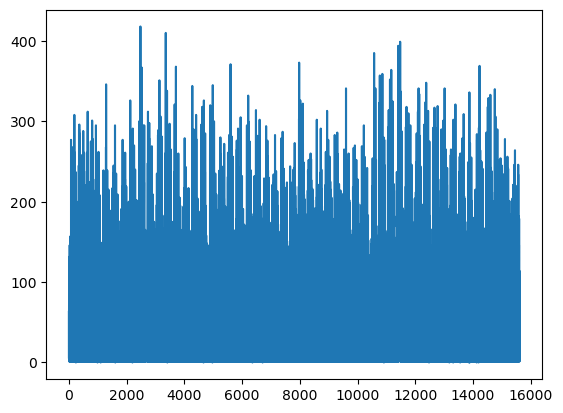

In [2]:
import matplotlib.pyplot as plt
plt.plot(DataFormat['Node']['TrafficNode'][:, 0])
plt.show()